In [11]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from jax import jit, config
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import numpy as np
from jax import jit, grad
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft

cpu


In [22]:
sampling = "mw"
multiresolution = True
reality = True
nside = None
L = 32
N = 1
J_min = 0

# Target map

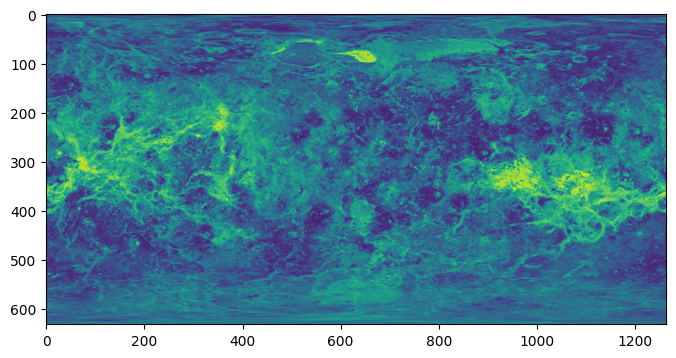

In [23]:
reload(sphlib)
# Random noise
# np.random.seed(0)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)

# Planet image
grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
I = pil_to_array(grayscale_pil_image)
L_temp = I.shape[0]


# Plot the map
plt.figure(figsize=(8, 6))
plt.imshow(I)
# hp.mollview(I)


(32, 63)


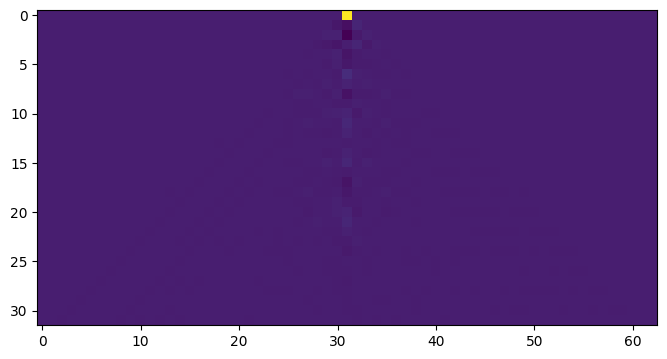

In [25]:
# SHT forward transform
Ilm = s2fft.forward_jax(I[:, :-1], L, sampling=sampling, nside=nside, reality=reality)
Ilm = Ilm[:L, L_temp-L: L_temp-1+L]  # Cut at the right resolution
print(Ilm.shape)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm))

I = s2fft.inverse_jax(Ilm, L, reality=reality)
plt.imshow(I, vmax=mx, vmin=mn, cmap='plasma')



# Wavelets

(6, 32, 63)


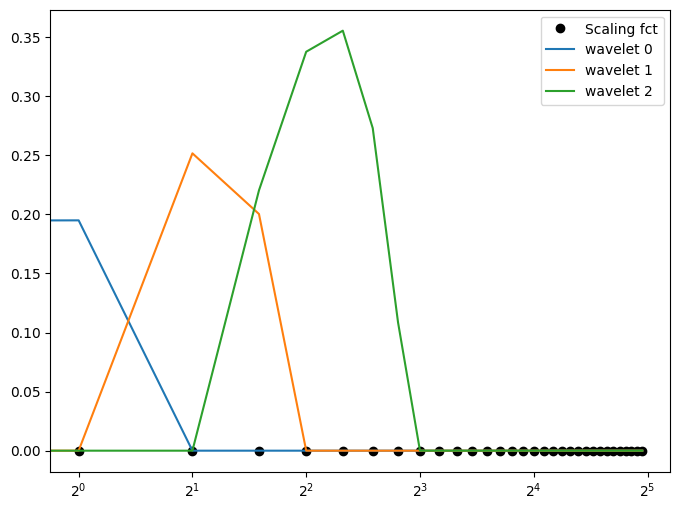

In [27]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plt.figure(figsize=(8, 6))
plt.plot(filters[1], 'ko', label='Scaling fct')
for j in range(3):
    plt.plot(np.real(filters[0])[j, :, L-1], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

In [28]:
# Compute the coeff of the target
mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm[:,L-1:], L, N, J_min, sampling, reality, multiresolution, filters=filters)
# mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm, L, N, J_min, sampling, reality, multiresolution, filters=filters)


# Define the loss

In [29]:
def chi2(model, data):
    return jnp.sum(jnp.square(data - model))

def func(flm):
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_axi(flm, L, N, J_min, sampling, reality, multiresolution, normalisation=P00, filters=filters)

    # Control for mean + var
    loss = jnp.abs(mean-mean_new)**2
    loss += jnp.abs(var-var_new)**2
    
    # Add S1 loss
    loss += jnp.sum(jnp.abs(S1-S1_new)**2)

    # Add P00 loss
    loss += jnp.sum(jnp.abs(P00-P00_new)**2)

    # Add C01 loss
    loss += jnp.sum(jnp.abs(C01-C01_new)**2)
    
    # Add C11 loss
    loss += jnp.sum(jnp.abs(C11-C11_new)**2)
    
    return loss

grad_func = jit(grad(func))



In [30]:
### Initial condition
f = np.random.randn(L,2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)
loss_0 = func(flm_start)

In [31]:
iterations = 10
momentum = 0.1
for i in range(iterations):
    flm -= momentum*np.conj(grad_func(flm))
    if i % 10 == 0: 
        print(f"Iteration {i}: Loss/Loss-0 = {func(flm)}/{loss_0}, Momentum = {momentum}")

Iteration 0: Loss/Loss-0 = 10525.060837772615/10869.565486825573, Momentum = 0.1


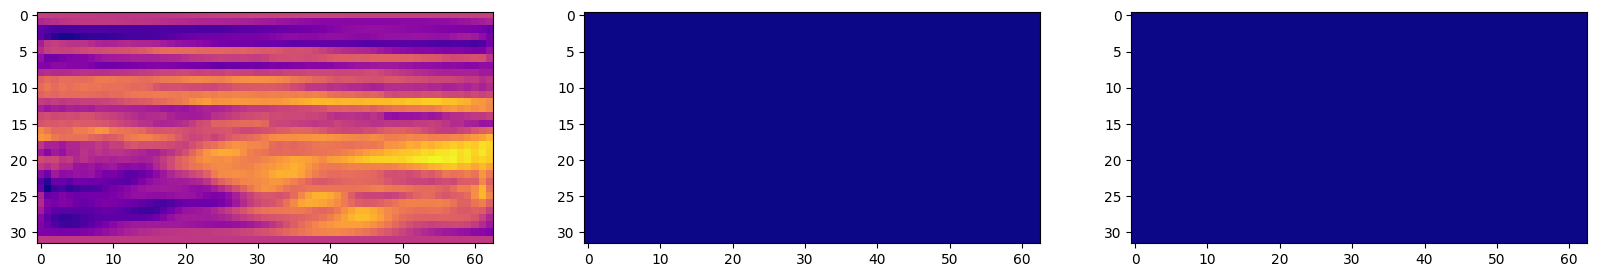

In [32]:
from matplotlib import pyplot as plt 

if reality:
    # Create and store signs 
    msigns = (-1)**jnp.arange(1,L)

    # Reflect and apply hermitian symmetry
    flm_full_end = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_end = flm_full_end.at[:,L-1:].set(flm)
    flm_full_end = flm_full_end.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_end[:, L:])*msigns, axis=-1))

    # Reflect and apply hermitian symmetry
    flm_full_start = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_start = flm_full_start.at[:,L-1:].set(flm_start)
    flm_full_start = flm_full_start.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_start[:, L:])*msigns, axis=-1))

I = s2fft.inverse_jax(Ilm, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)

mx, mn = np.nanmax(I), np.nanmin(I)
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(I, vmax=mx, vmin=mn, cmap='plasma')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='plasma')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='plasma')
plt.show()

In [ ]:
def compute_ps(flm):
    return jnp.sum(jnp.abs(flm)**2,axis=-1)

In [ ]:
from matplotlib import pyplot as plt 
ps_true = compute_ps(Ilm)
ps_start = compute_ps(flm_start)
ps_end = compute_ps(flm)
plt.plot(ps_true, label="target")
plt.plot(ps_start, label="start")
plt.plot(ps_end, label="end")
plt.yscale("log")
plt.legend()
plt.show()